In [1]:
# Load split

import pickle

badIDs = [605515760919, 601983541597]

with open('../../Splits/RegressionAllTasks/split1.bin', 'rb') as f:
    d = pickle.load(f)
    train = []
    trainDirty = d['train']
    test = []
    testDirty = d['test']
    
    # Remove bad subjects
    for subj in trainDirty:
        if subj['ID'] not in badIDs:
            train.append(subj)
            
    for subj in testDirty:
        if subj['ID'] not in badIDs:
            test.append(subj)
    
print(len(train))
print(len(test))

466
156


In [2]:
# Test 3-way

import numpy as np
import ThreeWay

def numCorEntries(nRoi):
    m1 = nRoi-1
    return int(m1**3/6+m1**2+(11/6)*m1+1)

a = np.array([[[0,1,1],[0,2,1]]], dtype='float32')
print(a.shape)
print(numCorEntries(a.shape[1]))
b = np.zeros([a.shape[0], numCorEntries(a.shape[1])], dtype='float32')
_ = ThreeWay.ThreeWay(a,b)
print(b)

(1, 2, 3)
4
[[2. 3. 5. 9.]]


In [3]:
# Test 3-way time

import time

t0 = time.time()
a = np.ones([4,264,124], dtype='float32')
b = np.zeros([4,numCorEntries(264)], dtype='float32')
_ = ThreeWay.ThreeWay(a,b)
t1 = time.time()
print(b[0,0:2])
print(b.shape)
print(b.shape[1]*466*4)
tp = t1-t0
print('{:f} s, {:f} s'.format(tp, tp*(466/4)))

[124. 124.]
(4, 3101560)
5781307840
17.692527 s, 2061.179402 s


In [4]:
# Load data

def loadTimeseries(_id, _dir):
    ts = None
    with open('{:s}/{:d}.bin'.format(_dir, _id), 'rb') as f:
        ts = pickle.load(f)
    return ts

train_rest_ts = [loadTimeseries(int(subj['rest']), '../../rest_fmri_power264/timeseries') for subj in train]
# train_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in train]
# train_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in train]

test_rest_ts = [loadTimeseries(int(subj['rest']), '../../rest_fmri_power264/timeseries') for subj in test]
# test_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in test]
# test_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in test]

print('Complete')

Complete


In [5]:
import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(train_rest_ts)
# normalizeSubjects(train_nback_ts)
# normalizeSubjects(train_emoid_ts)

normalizeSubjects(test_rest_ts)
# normalizeSubjects(test_nback_ts)
# normalizeSubjects(test_emoid_ts)

print('Complete')

Complete


In [6]:
train_rest_ts_f32 = np.stack(train_rest_ts).astype('float32')
test_rest_ts_f32 = np.stack(test_rest_ts).astype('float32')

print(train_rest_ts_f32.shape)
print(test_rest_ts_f32.shape)

(466, 264, 124)
(156, 264, 124)


In [10]:
import time

t0 = time.time()
train_rest_3way = np.empty([train_rest_ts_f32.shape[0], numCorEntries(train_rest_ts_f32.shape[1])], 
                           dtype='float32')
print(train_rest_3way.shape)
_ = ThreeWay.ThreeWay(train_rest_ts_f32, train_rest_3way)
t1 = time.time()

print('Complete {:f}s'.format(t1-t0))

(466, 3101560)
Complete 1832.449205s


In [11]:
import pickle

with open('train_rest_3way.bin', 'wb') as f:
    pickle.dump(train_rest_3way, f)
    
print('Complete')

Complete


In [12]:
# Create feature vectors (right now just ages, maleness, and femaless)

X_train = []
for subj in train:
    maleness = 1 if subj['meta']['Gender'] == 'M' else 0
    femaleness = 1 if maleness == 0 else 0
    feat = np.array([subj['meta']['AgeInMonths'], maleness, femaleness])
    X_train.append(feat)
    
X_test = []
for subj in test:
    maleness = 1 if subj['meta']['Gender'] == 'M' else 0
    femaleness = 1 if maleness == 0 else 0
    feat = np.array([subj['meta']['AgeInMonths'], maleness, femaleness])
    X_test.append(feat)
    
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

print(X_train[10:20])
print('Complete')

[[193   1   0]
 [217   1   0]
 [233   1   0]
 [176   1   0]
 [116   0   1]
 [246   0   1]
 [164   1   0]
 [167   0   1]
 [202   0   1]
 [108   0   1]]
Complete


In [13]:
print('Starting')

w, res, _, _ = np.linalg.lstsq(train_rest_3way, X_train[:,0], rcond=None)

print('Finished')

pTrain = train_rest_3way @ w
print(np.sum((X_train[:,0] - pTrain)**2/X_train.shape[0])**0.5/12)

Starting


<ipython-input-13-0cabcc196cca>:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w, res, _, _ = np.linalg.lstsq(train_rest_3way, X_train[:,0])


Finished
2.5988322920292155e-13


In [14]:
print(w.shape)

(3101560,)


In [15]:
print(np.mean(np.abs(w)))

5.0482530657606983e-05


In [16]:
import time

t0 = time.time()
test_rest_3way = np.empty([test_rest_ts_f32.shape[0], numCorEntries(test_rest_ts_f32.shape[1])], 
                          dtype='float32')
print(test_rest_3way.shape)
_ = ThreeWay.ThreeWay(test_rest_ts_f32, test_rest_3way)
t1 = time.time()

print('Complete {:f}s'.format(t1-t0))

(156, 3101560)
Complete 577.424277s


In [20]:
predY = test_rest_3way @ w

res = predY - X_test[:,0]
print((np.sum(res**2)/test_rest_3way.shape[0])**0.5/12)
print(np.mean(np.abs(res/12)))

12.38336194431441
10.619542937601704


[[ 1.         -0.00206284]
 [-0.00206284  1.        ]]
12.383361944314409
10.619542937601702


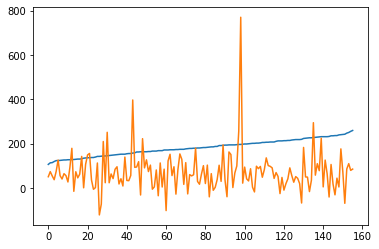

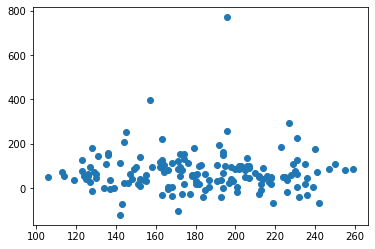

In [21]:
import matplotlib.pyplot as plt

idcs = np.argsort(X_test[:,0])
yPred = predY[idcs]
y = X_test[:,0][idcs]

corr = np.corrcoef(y, yPred)
rmse = (np.sum((y-yPred)**2)/len(y))**0.5/12
mae = np.sum(np.abs(y-yPred))/12/len(y)

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(yPred, label='Prediction')
plt.show()

plt.scatter(y, yPred)
plt.show()